In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd 'drive/My Drive/AI와 기후변화 20231101'

/content/drive/My Drive/AI와 기후변화 20231101


In [4]:
import os
print(os.getcwd())

/content/drive/My Drive/AI와 기후변화 20231101


In [13]:
climate_data = pd.read_csv('./기후변화 데이터/asos003_SQM_ACCESS-CM2_ssp585.csv')
climate_data['YR'] = [str(x) for x in climate_data['YR']]
climate_data['MM'] = [str(x).zfill(2) for x in climate_data['MM']]
climate_data['DD'] = [str(x).zfill(2) for x in climate_data['DD']]

climate_data  = climate_data.groupby(by=['YR', 'MM']).sum()
climate_data = climate_data.reset_index()
climate_data['YMD'] = climate_data['YR'] + '-' + climate_data['MM']
climate_data.index = pd.to_datetime(climate_data['YMD'])
climate_data = climate_data[['PCP']]
climate_data

<ipython-input-13-c7953b6c51c6>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  climate_data  = climate_data.groupby(by=['YR', 'MM']).sum()


,PCP
YMD,
2011-01-01,3.995873
2011-02-01,4.347991
2011-03-01,5.213588
2011-04-01,47.391880
2011-05-01,22.971377
...,...
2100-08-01,688.434190
2100-09-01,2.709942
2100-10-01,0.517549


In [14]:
#Standardized Precipitation Index Function
def spi(ds, thresh):

    ds_ma = ds.rolling(thresh, center=False).mean() #thresh만큼 이동평균

    ds_In = np.log(ds_ma) # gamma 분포의 파라미터 추정을 위해 log 변환
    ds_In[np.isinf(ds_In) == True] = np.nan # inf가 있는 경우 NaN으로 대체 -> log 변환시 0과 같은 값은 inf 발생

    ds_mean = np.nanmean(ds_ma) # NaN를 제외한 전체 기간에 대한 평균

    ds_sum = np.nansum(ds_In) # 로그 변환된 값에 대해 NaN을 제외한 전체 기간에 대한 합

    #Computing essentials for gamma distribution
    n = len(ds_In[thresh-1:])                  # 지속기간별 데이터 길이
    A = np.log(ds_mean) - (ds_sum/n)           # alpha를 구하기 위한 A 계산
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   # gamma 분포의 파라미터 alpha 계산 :
    beta = ds_mean/alpha                       # gamma 분포의 beta 계산

    # alpha, beta : gamma 분포를 구하기 위한 파라미터

    gamma = st.gamma.cdf(ds_ma, a=alpha, scale=beta) # gamma 분포의 CDF 구하기

    norm_spi = st.norm.ppf(gamma, loc=0, scale=1)

    return ds_ma, ds_In, ds_mean, ds_sum, n, A, alpha, beta, gamma, norm_spi

In [15]:
data = climate_data.copy()
times = [3, 6, 9, 12, 24]
for i in times:
    x = spi(data['PCP'], i)
    data['spi_'+str(i)] = x[9]

In [16]:
data

,PCP,spi_3,spi_6,spi_9,spi_12,spi_24
YMD,,,,,,
2011-01-01,3.995873,NaN,NaN,NaN,NaN,NaN
2011-02-01,4.347991,NaN,NaN,NaN,NaN,NaN
2011-03-01,5.213588,-1.721464,NaN,NaN,NaN,NaN
2011-04-01,47.391880,-0.902817,NaN,NaN,NaN,NaN
2011-05-01,22.971377,-0.708290,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2100-08-01,688.434190,2.054571,2.289157,2.202252,2.699265,2.191421
2100-09-01,2.709942,2.037448,2.132160,2.207202,2.488357,2.151793
2100-10-01,0.517549,1.539680,2.026358,2.206687,1.954640,1.541256


[(0, array([<Axes: >, <Axes: >, <Axes: >], dtype=object)), (1, array([<Axes: >, <Axes: >, <Axes: >], dtype=object)), (2, array([<Axes: >, <Axes: >, <Axes: >], dtype=object)), (3, array([<Axes: >, <Axes: >, <Axes: >], dtype=object)), (4, array([<Axes: >, <Axes: >, <Axes: >], dtype=object))]


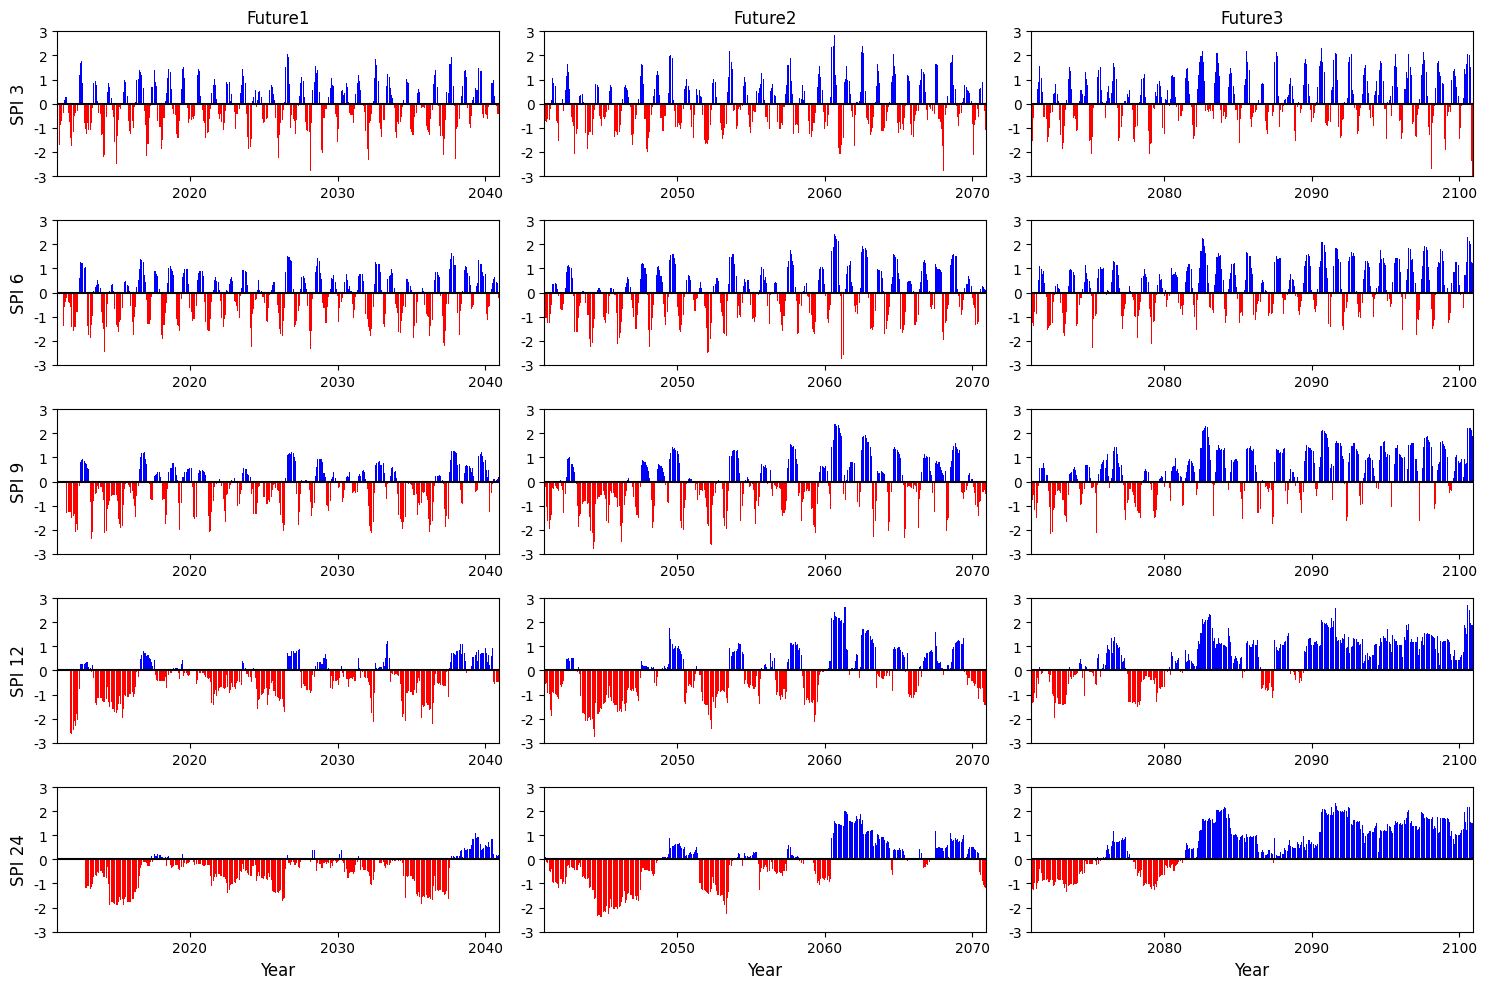

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=3,figsize=(15, 10))
print (list((enumerate(axes))))
plt.subplots_adjust(hspace=0.15)
for i, ax in enumerate(axes):
    for j, a in enumerate(ax):
        d=data[j*30*12:(j+1)*30*12]
        col_scheme=np.where(d['spi_'+str(times[i])]>0, 'b','r')
        a.bar(d.index, d['spi_'+str(times[i])], width=25, align='center', color=col_scheme, label='SPI '+str(times[i]))
        a.set_ylim(-3,3)
        a.set_xlim(d.index[0],d.index[-1])
        a.axhline(y=0, color='k')
        a.xaxis.set_major_locator(mdates.YearLocator(10))
        a.set_yticks(range(-3,4), range(-3,4))
        if j==0:
            a.set_ylabel('SPI '+str(times[i]), fontsize=12)
        if i==0 and j==0:
            a.set_title('Future1', fontsize=12)
        if i==0 and j==1:
            a.set_title('Future2', fontsize=12)
        if i==0 and j==2:
            a.set_title('Future3', fontsize=12)
        if i==4:
            a.set_xlabel('Year', fontsize=12)
fig.tight_layout()

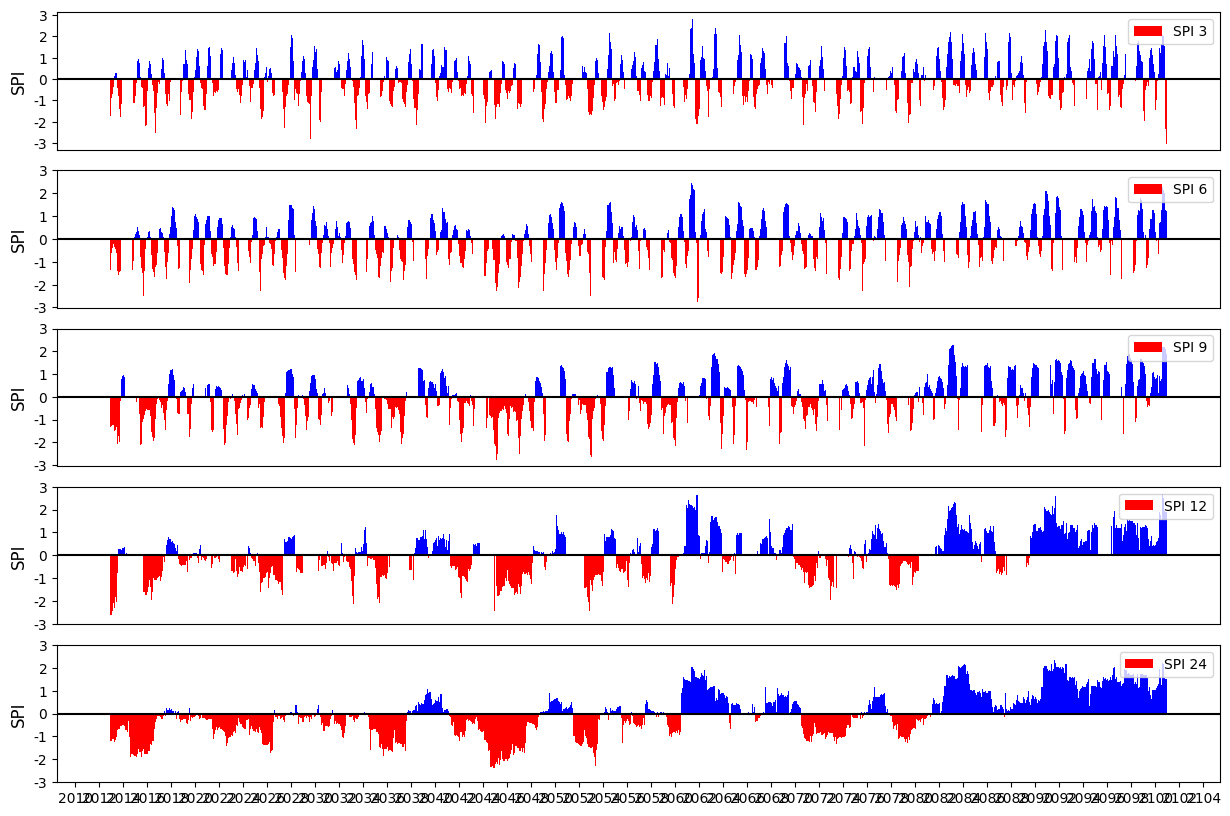

In [18]:
fig, axes = plt.subplots(nrows=5, figsize=(15, 10))
plt.subplots_adjust(hspace=0.15)
for i, ax in enumerate(axes):
    col_scheme=np.where(data['spi_'+str(times[i])]>0, 'b','r')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.bar(data.index, data['spi_'+str(times[i])], width=25, align='center', color=col_scheme, label='SPI '+str(times[i]))
    ax.axhline(y=0, color='k')
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.legend(loc='upper right')
    ax.set_yticks(range(-3,4), range(-3,4))
    ax.set_ylabel('SPI', fontsize=12)

    if i<len(times)-1:
        ax.set_xticks([],[])